In [ ]:
#1. Import packages
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from keras import layers,losses,callbacks,activations,regularizers,metrics,applications,optimizers
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, os
import keras
from sklearn.model_selection import train_test_split

filepath = r"C:\Users\suhaimi\Desktop\YPAI11\Capstone\segmentation_project"
images = []
masks = []

In [3]:
#2. Load images
image_path = os.path.join(filepath,'train','inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    img_np = cv2.resize(img_np,(128,128))
    #Place the image into the empty list
    images.append(img_np)

image_path = os.path.join(filepath,'test','inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    img_np = cv2.cvtColor(img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    img_np = cv2.resize(img_np,(128,128))
    #Place the image into the empty list
    images.append(img_np)

#3. Load masks
mask_path = os.path.join(filepath,'train','masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    mask_np = cv2.resize(mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(mask_np)

mask_path = os.path.join(filepath,'test','masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    mask_np = cv2.resize(mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(mask_np)

In [4]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [5]:
#5. Data preprocessing
# Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
# Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
# Normalize the images pixel value
normalized_images_np = images_np/255.0

In [6]:
#6. Perform train test split
SEED = 12345
X_train,X_test,y_train,y_test = train_test_split(normalized_images_np,converted_masks_np,shuffle=True,random_state=SEED)

In [7]:
#7. Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [8]:
#8. Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [9]:
# 9. Create a custom class for augmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
# 10. Use the functions to extract the feautures and labels
TRAIN_LENGTH = 670
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Prepare the dataset
train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test.batch(BATCH_SIZE)

In [11]:
# 11. Create a function to visualize the image, label and prediction
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

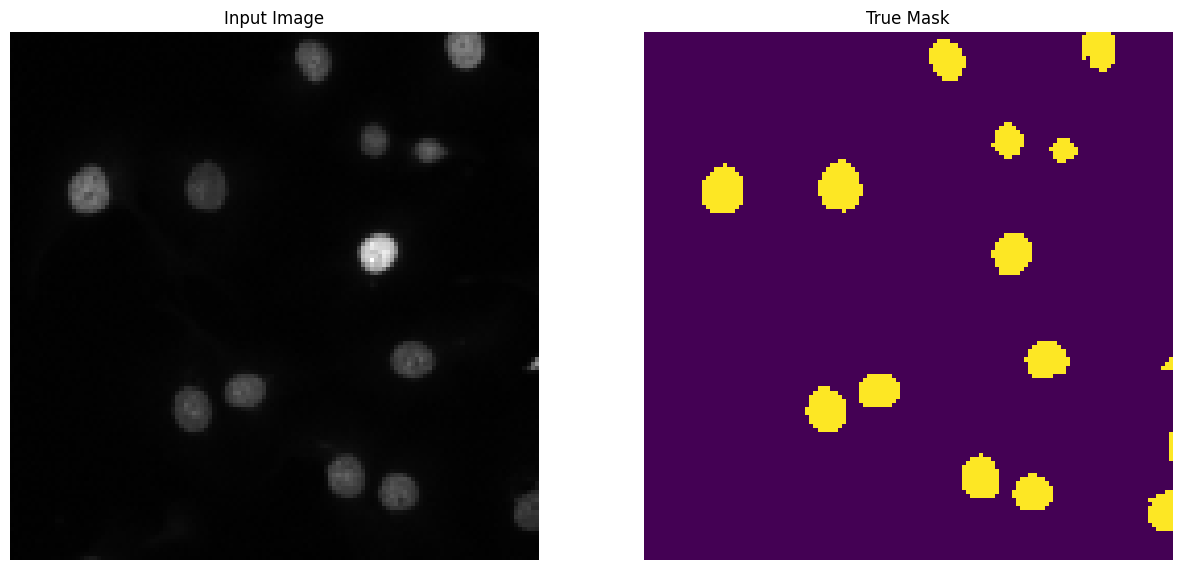

(128, 128, 3)
(128, 128, 1)


In [12]:
# 12. Test out the function to display an example
for images,labels in train_batches.take(1):
    sample_image,sample_mask = images[0],labels[0]
    display([sample_image,sample_mask])
    print(sample_image.shape)
    print(sample_mask.shape)

In [13]:
# 13. Model development
# Get the pretrained model as feature extractor using keras.applications
base_model = applications.MobileNetV2(input_shape=sample_image.shape,include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [14]:
# 14. Properly create the downsampling path of the model
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# Freeze the feature extractor
down_stack.trainable = False

In [15]:
# 15. Create the upsampling layers
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
up_stack[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 16. Create a function to construct the Unet model
def unet_model(output_channels:int):
    # Use functional API to build the model
    # (A) Start with the input
    inputs = keras.Input(shape=sample_image.shape)
    # (B) Followed by the feature extractor
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    # (C) Build the upsampling path by concatenate with the outputs from feature extractor, along with using the upsampling layers
    for up, skip in zip(up_stack, skips):
        # Perform the upsampling first
        x = up(x)
        # Concatenate the output from the upsampling layer with the previous pooling layer
        concat = layers.Concatenate()
        x = concat([x,skip])
    # (D) Perform one last upsampling to restore back to original resolution
    last = layers.Conv2DTranspose(filters=output_channels,kernel_size=3,strides=2,padding='same')   # 64x64 --> 128x128
    x = last(x)
    model = keras.Model(inputs=inputs,outputs=x)
    return model


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      2,882 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,502,786 (24.81 MB)

 Trainable params: 4,658,882 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

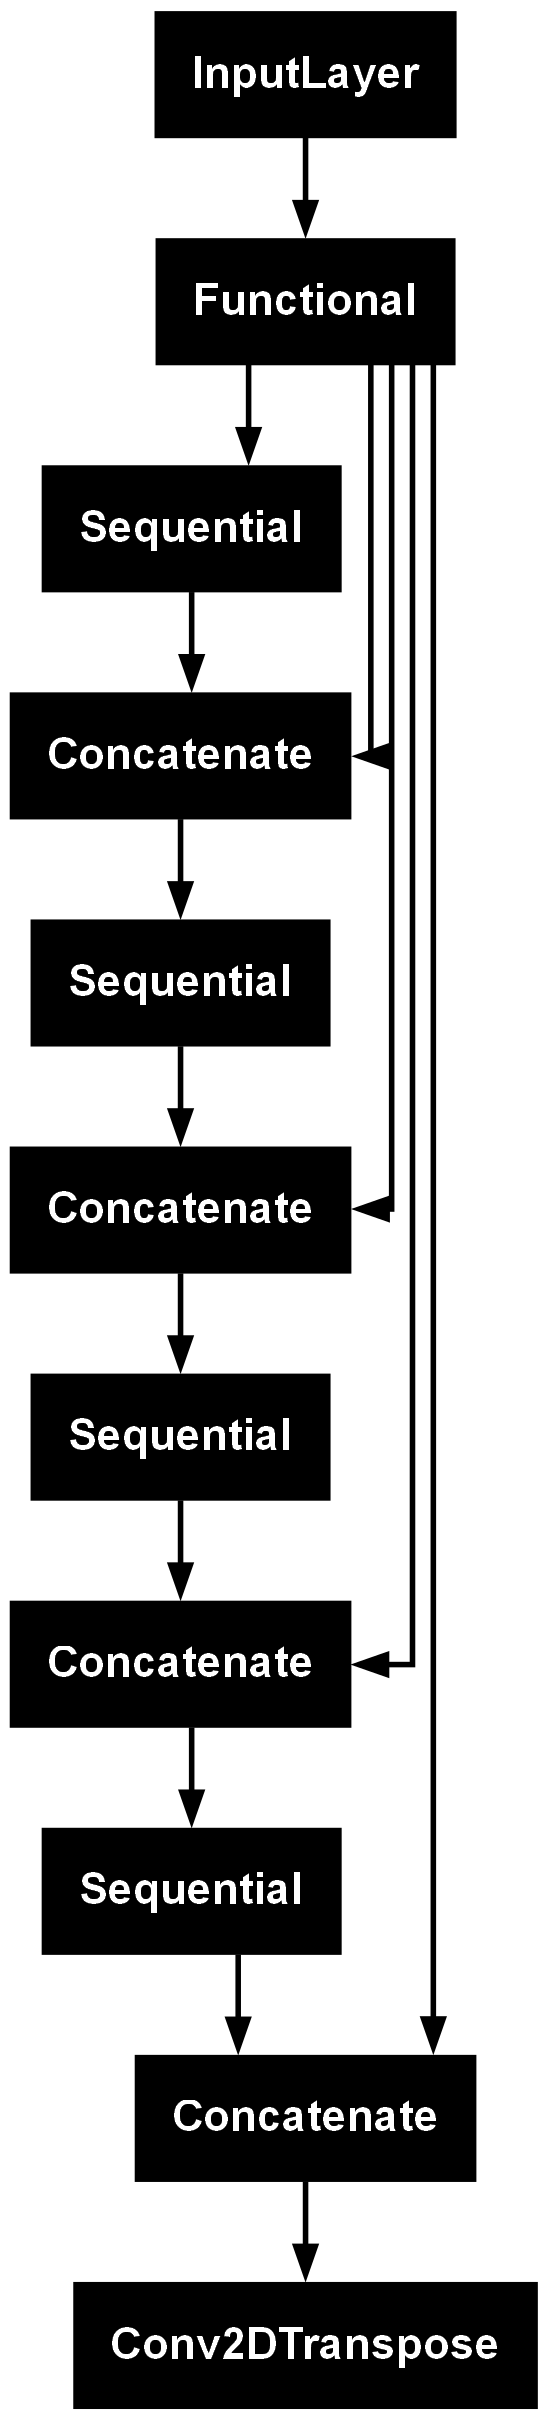

In [17]:
# 17. Use the function to create the Unet
model = unet_model(output_channels=2)
model.summary()
keras.utils.plot_model(model)

In [18]:
# 18. Compile the model
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

In [19]:
# 19. Create a custom callback to display result in the middle of the training.
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [20]:
# 20. Prepare for the training
import os,datetime
logpath = os.path.join("seg_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_dir=logpath)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


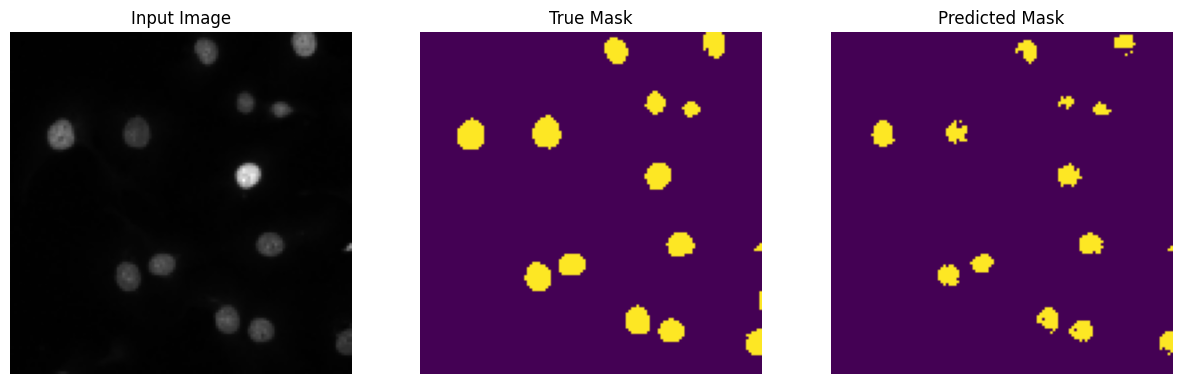


Sample Prediction after epoch 7

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 924ms/step - accuracy: 0.9561 - loss: 0.1078 - val_accuracy: 0.9015 - val_loss: 0.1921
Epoch 7: early stopping


In [21]:
# 21. Model training
es = callbacks.EarlyStopping(patience=3,verbose=1)
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 670 // BATCH_SIZE // VAL_SUBSPLITS
model_history = model.fit(
    x=train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_batches,
    validation_steps=VALIDATION_STEPS,
    callbacks=[es,tb,DisplayCallback()]
)

In [22]:
# 22. Evaluate the model
print(model.evaluate(test_batches))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.9047 - loss: 0.1851
[0.18044106662273407, 0.9067710041999817]


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


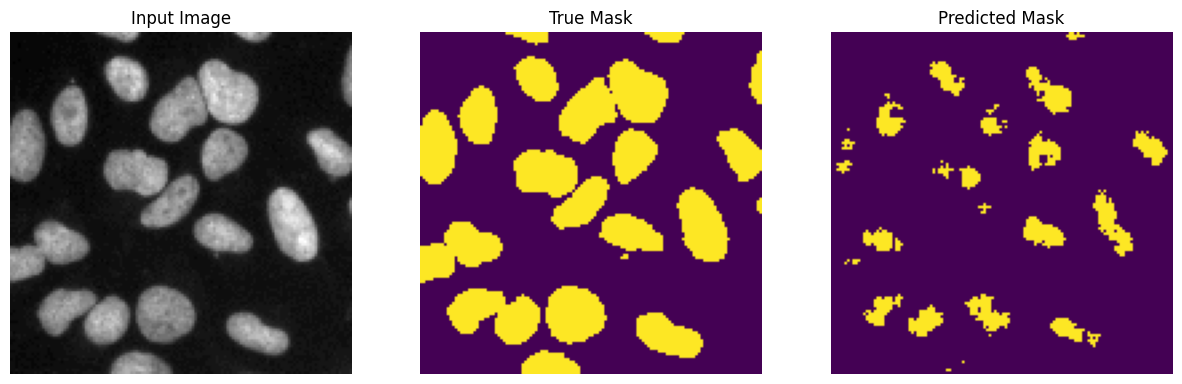

In [23]:
# 23. Use the model to make prediction
import numpy as np
for test_img,test_label in test_batches.take(1):
    predictions = model.predict(test_img)
    predictions = np.argmax(predictions,axis=-1)
    predictions = np.expand_dims(predictions,axis=-1)

# Take a data out to plot
display([test_img[32],test_label[32],predictions[32]])

In [24]:
# 24. Save the model
model.save('model/model1.keras')